# 全卷积网络



In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

使用在ImageNet数据集上预训练的ResNet-18模型来提取图像特征

| 索引    | 模块名           | 功能                |
| ----- | ------------- | ----------------- |
| 0     | `conv1`       | 初始7×7卷积           |
| 1     | `bn1`         | 批归一化              |
| 2     | `relu`        | 激活函数              |
| 3     | `maxpool`     | 最大池化              |
| 4     | `layer1`      | 残差块组1             |
| 5     | `layer2`      | 残差块组2             |
| 6     | `layer3`      | 残差块组3             |
| **7** | **`layer4`**  | **残差块组4（最后卷积层）**  |
| **8** | **`avgpool`** | **全局平均池化**        |
| **9** | **`fc`**      | **全连接分类层（1000类）** |


In [14]:
pretrained_net = torchvision.models.resnet18(pretrained=True) # 获取模型的直接子模块（返回一个迭代器）
list(pretrained_net.children())[-3:] # 转换为列表以便索引，Python切片语法，取列表的 最后三个元素

e:\Anaconda3\envs\DL\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Anaconda3\envs\DL\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

创建一个全卷积网络`net`

| 层名               | 操作                | 输出尺寸变化（高×宽）         | 通道数           |
| ---------------- | ----------------- | ------------------- | ------------- |
| 输入 X   | -                 | `320 × 480`         | 3             |
| conv1            | 7×7, stride=2     | `160 × 240`         | 64            |
| maxpool          | 3×3, stride=2     | `80 × 120`          | 64            |
| layer1           | 残差块×2             | `80 × 120`          | 64            |
| layer2           | 残差块×2（首块stride=2） | `40 × 60`           | 128           |
| layer3           | 残差块×2（首块stride=2） | `20 × 30`           | 256           |
| layer4  | 残差块×2（首块stride=2） | `10 × 15`  |  512  |


In [16]:
'''
pretrained_net.children(): ResNet-18的10个子模块
[:-2]: 去掉最后两个（全局池化 + 全连接层）
*解包: 将剩余的8个子模块作为独立参数传入
nn.Sequential(...): 将它们串联成新模型 net
net 包含的层：conv1 → bn1 → relu → maxpool → layer1 → layer2 → layer3 → layer4
'''
net = nn.Sequential(*list(pretrained_net.children())[:-2])

X = torch.rand(size=(1, 3, 320, 480)) # 一张RGB彩色图像(批量大小, 通道数, 高度, 宽度)
net(X).shape

torch.Size([1, 512, 10, 15])

使用$1\times1$卷积层将输出通道数转换为Pascal VOC2012数据集的类数（21类）。
将特征图的高度和宽度增加32倍

为什么用转置卷积？<br>
1. 可学习上采样：相比双线性插值，参数可训练
2. 端到端训练：整个网络可以反向传播联合优化
3. FCN-32s经典设计：单尺度直接上采样到原图

参数计算验证<br>
上采样尺寸公式 ：<br>
output = (input - 1) × stride - 2×padding + kernel_size

| 层名                   | 操作    | 步长                 | 输出尺寸          | 累计缩小倍数          |
| -------------------- | ----- | ------------------ | ------------- | --------------- |
| **输入**               | -     | -                  | `320 × 480`   | **×1**          |
| `conv1`              | 7×7卷积 | **stride=2**       | `160 × 240`   | **×2**          |
| `maxpool`            | 3×3池化 | **stride=2**       | `80 × 120`    | **×4**          |
| `layer1`             | 残差块×2 | stride=1           | `80 × 120`    | **×4**          |
| `layer2`             | 残差块×2 | **stride=2**       | `40 × 60`     | **×8**          |
| `layer3`             | 残差块×2 | **stride=2**       | `20 × 30`     | **×16**         |
| `layer4` ` | 残差块×2 | stride=2 | **`10 × 15`** | `×32`  |


In [4]:
'''
输入图像: (3, 320, 480)
    ↓ ResNet backbone
特征图: (512, 10, 15)  # 缩小32倍
    ↓ final_conv (1×1卷积)
类别分数: (21, 10, 15)  # 每个像素21类分数
    ↓ transpose_conv (stride=32上采样)
预测图: (21, 320, 480)  # 还原到原图尺寸
'''
num_classes = 21
'''
1×1 卷积降维
in_channels=512:输入512通道（ResNet特征）
out_channels=num_classes=21:输出21通道（Pascal VOC类别数）;通道:512→21
kernel_size=1:1×1卷积（无空间混合）;空间尺寸:不变
作用 ：将低分辨率特征图上采样32倍，恢复到输入图像的原始空间分辨率。
输出形状：(batch, 21, H, W)
'''
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))
'''
转置卷积上采样
in/out_channels=21:通道数不变;通道:21→21
kernel_size=64:64×64大卷积核
stride=32:放大32倍;空间尺寸:(H/32, W/32)→(H, W)
padding=16:保持边缘对齐
'''
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes,
                                    kernel_size=64, padding=16, stride=32))

📉 下采样 (Downsampling) = 缩小图像/特征图<br>
定义：将高分辨率数据压缩为低分辨率，减少像素/特征数量。<br>
比喻：用 Photoshop 缩小图片尺寸，或用缩略图看大图。<br>
深度学习中的实现方式：<br>
池化层 (Max/Avg Pooling)<br>
步长大于1的卷积 (Stride > 1)<br>
跳像素采样（如每隔一个像素取一个）<br>
📈 上采样 (Upsampling) = 放大图像/特征图<br>
定义：将低分辨率数据恢复为高分辨率，增加像素/特征数量。<br>
比喻：用 Photoshop 放大图片尺寸，但要"脑补"缺失的像素。<br>
深度学习中的实现方式：<br>
转置卷积 (ConvTranspose2d) —— 可学习上采样<br>
插值法 (双线性/最近邻插值) —— 固定规则上采样<br>
上采样层 (Upsample)<br>

| 特性             | 下采样                             | 上采样                           |
| -------------- | ------------------------------- | ----------------------------- |
|  目的   | 压缩信息、扩大感受野、减少计算                 | 恢复分辨率、像素级预测、图像生成              |
|  操作    | 合并/丢弃像素                         | 插入/生成像素                       |
|  典型层   | `MaxPool2d`, `Conv2d(stride>1)` | `ConvTranspose2d`, `Upsample` |
|  数值变化  | 信息丢失（不可逆）                       | 信息创造（需学习）                     |
|  应用场景  | 分类网络的特征提取                       | 分割、超分辨率、GAN                   |


在深度学习中的应用<br>
下采样用于：<br>
图像分类（ResNet的layer1-4逐步缩小）<br>
特征金字塔（提取多尺度特征）<br>
降低显存占用<br>
上采样用于：<br>
语义分割（FCN、U-Net：下采样→上采样）<br>
图像超分辨率（SRGAN：低清→高清）<br>
生成模型（Stable Diffusion：噪声→图像）<br>
下采样 = 压缩提取精华，上采样 = 扩展还原细节。两者像"压缩-解压"的配对，但上采样不是下采样的严格逆运算（信息不可逆），需要用神经网络"学习"如何重建。

初始化转置卷积层

二维可分离线性插值核函数<br>
$w(i,j)=(1-\frac{\left | i-c \right | }{f} ) \times (1-\frac{\left | j-c\right |}{f} )$

其中：<br>
(i,j) ：核内坐标位置<br>
c ：中心点（center）<br>
f ：缩放因子（factor）<br>
定义域：∣i−c∣≤f  且 ∣j−c∣≤f （超出范围权重为0）<br>
一维线性插值:在两个点$x_{1}$和$x_{2}$之间，任意点x的插值权重：<br>
$w(x)=1-\frac{\left |x-x_{1}\right |}{x_{2}-x_{1}} $<br>
二维双线性插值:将两个方向独立 进行线性插值，然后相乘（利用可分离性）：<br>
$w(i,j)=w(i) \times w(j)$


In [5]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    # 1. 计算中心和缩放因子
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1 # 中心在整数位置
    else:
        center = factor - 0.5 # 中心在半像素位置
    '''
    2. 创建坐标网格
    # og[0](形状: 4x1):# 垂直方向坐标
    [[0],
    [1],
    [2],
    [3]]
    og[1] (形状: 1x4):# 水平方向坐标    [[0, 1, 2, 3]]
    '''
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    # 3. 计算二维双线性权重
    # \ 是 Python 的折行符
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    # 4. 创建并填充权重矩阵
    weight = torch.zeros((in_channels, out_channels,
                          kernel_size, kernel_size))# 1. 创建全零权重张量
    '''
    输出通道
      0    1    2
    ┌────┬────┬────┐
  0 │filt│ 0  │ 0  │
    ├────┼────┼────┤
入1 │ 0  │filt│ 0  │
    ├────┼────┼────┤
  2 │ 0  │ 0  │filt│
    └────┴────┴────┘
    '''
    weight[range(in_channels), range(out_channels), :, :] = filt # 2. 赋值对角线位置
    return weight

双线性插值的上采样实验

input image shape: torch.Size([231, 294, 3])
output image shape: torch.Size([462, 588, 3])


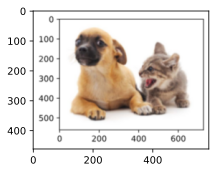

In [6]:
'''
原始图像: (C, H, W)
    ↓ unsqueeze(0)
网络输入: (1, C, H, W)
    ↓ ConvTranspose2d(stride=2)
上采样输出: (1, C, 2H, 2W)
    ↓ [0].permute(1,2,0).detach()
可视化图像: (2H, 2W, C)
1. 创建转置卷积层（上采样）
输入3通道 → 输出3通道（RGB图像）
kernel_size=4: 4×4卷积核
stride=2: 空间尺寸放大2倍（上采样的关键）
padding=1: 保持输出尺寸为输入的整数倍
bias=False: 无需偏置（纯插值操作）
output = (input - 1) × stride - 2×padding + kernel_size
'''
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2,
                                bias=False)
'''
2. 用双线性插值核初始化权重
bilinear_kernel(3, 3, 4) 生成4×4的双线性插值核（对角线初始化）
使转置卷积初始时等价于双线性插值放大,后续训练可学习更优的上采样模式
'''
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4));
# 3. 加载并预处理图像
# Image.open: 加载图片（PIL格式）
# ToTensor(): 转换为PyTorch张量，维度从(H,W,C)→(C,H,W)，像素值归一化到[0,1]
img = torchvision.transforms.ToTensor()(d2l.Image.open('../img/catdog.jpg'))
# 4. 增加Batch维度
# img 形状: (3, H, W),X 形状: (1, 3, H, W)模型需要4D输入
X = img.unsqueeze(0)
# 5. 执行上采样
# 输入 X: (1, 3, H, W);输出 Y: (1, 3, 2H, 2W)  # 空间尺寸放大2倍
Y = conv_trans(X)
# 6. 转换回图像格式
'''
Y[0]: 去掉batch维度 → (3,2H,2W)
permute(1, 2, 0): 维度重排 → (2H,2W,3)（matplotlib要求的格式）
detach(): 分离计算图（不再跟踪梯度）
'''
out_img = Y[0].permute(1, 2, 0).detach()
'''
set_figsize(): 设置绘图窗口大小
img.permute(1, 2, 0): 将原始图像转换为 (H, W, 3) 格式
out_img: 已转换好的 (2H, 2W, 3) 格式
imshow:  显示图像（前后对比）
'''
d2l.set_figsize()
print('input image shape:', img.permute(1, 2, 0).shape)
d2l.plt.imshow(img.permute(1, 2, 0));
print('output image shape:', out_img.shape)
d2l.plt.imshow(out_img);

用双线性插值的上采样初始化转置卷积层。对于$1\times 1$卷积层，我们使用Xavier初始化参数

In [7]:
# 1. 生成双线性插值核权重
'''
in_channels = num_classes（如21，Pascal VOC类别数）
out_channels = num_classes（输出通道数相同）
kernel_size = 64（大卷积核，用于32倍上采样）
'''
W = bilinear_kernel(num_classes, num_classes, 64)
# 2. 将权重加载到转置卷积层
'''
weight.data：直接访问底层的权重张量（绕过梯度计算）
.copy_()：原地复制（in-place），节省内存
初始化后，转置卷积在训练初期的行为等价于双线性插值
'''
net.transpose_conv.weight.data.copy_(W); # .copy_() 是原地操作

读取数据集

In [8]:
batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)

read 1114 examples
read 1078 examples


训练

loss 0.415, train acc 0.870, test acc 0.853
96.4 examples/sec on [device(type='cuda', index=0)]


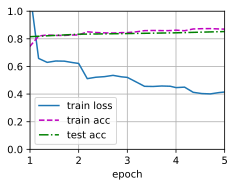

In [9]:
'''
inputs: 模型预测，形状 (batch, num_classes, H, W)
targets: 真实标签，形状 (batch, H, W)（像素级类别索引）
F.cross_entropy(..., reduction='none')：计算每个像素的交叉熵损失，返回形状 (batch, H, W)
.mean(1)：对高度维度求平均 → 形状 (batch, W)
.mean(1)：再对宽度维度求平均 → 形状 (batch,)（每个样本一个标量损失）
作用：在语义分割中，需要对每个像素分类，但最终损失要汇总成一个标量用于反向传播。
'''
def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus() # wd权重衰减（L2正则化），防止过拟合
'''
SGD：随机梯度下降
net.parameters()：优化网络所有可训练参数
weight_decay=wd：应用L2正则化
'''
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
'''
net: 待训练模型
train_iter: 训练数据加载器
test_iter: 测试数据加载器
loss: 自定义损失函数
trainer: 优化器
num_epochs, devices: 训练配置
'''
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

预测

In [10]:
'''
原始图像 (H, W, 3)
    ↓ normalize_image + unsqueeze
归一化张量 (1, 3, H, W)
    ↓ net 推理 + argmax
类别预测 (1, H, W)
    ↓ reshape
2D标签图 (H, W)
'''
# 输入一张图像，输出每个像素的类别预测（整数标签图）
def predict(img):
    '''
    normalize_image(img)：调用数据集的归一化方法（通常包括像素值归一化到 [0,1] 和标准化）
    .unsqueeze(0)：在最前面增加 batch 维度
    输入：img 形状 (H, W, 3) 或 (3, H, W)
    输出：X 形状 (1, 3, H, W) ← 模型要求的 4D 格式
    '''
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    '''
    X.to(devices[0])：将数据移到模型所在的设备（GPU/CPU）
    net(...)：前向传播，输出形状 (1, num_classes, H, W)
    每个像素有num_classes个分数（logits）
    .argmax(dim=1)：在类别维度取最大值索引
    核心：将分数转换为最可能的类别ID
    输出：pred 形状 (1, H, W)（整数标签图，每个像素是0~20的类别ID）
    '''
    pred = net(X.to(devices[0])).argmax(dim=1)
    '''
    pred.shape：(1, H, W) batch size;图像高度;图像宽度
    .reshape(H, W)：去掉batch维度，返回2D张量
    输出：形状 (H, W)，可直接用于可视化
    '''
    return pred.reshape(pred.shape[1], pred.shape[2])

可视化预测的类别

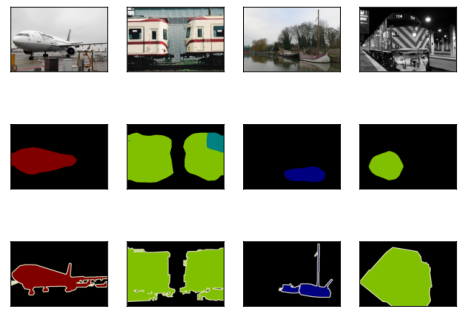

In [11]:
'''
1. label2image 函数：标签 → 彩色图
d2l.VOC_COLORMAP：VOC数据集的21类颜色映射表（每个类别对应一个RGB颜色，如背景=黑色，飞机=红色等）
例如：0=背景=[0,0,0]（黑色），1=飞机=[128,0,0]（红色），2=自行车=[0,128,0]（绿色）...
device=devices[0]：将颜色表移到模型所在的设备（GPU）
pred：模型预测结果，形状 (H, W)，每个元素是整数类别ID（0~20）
.long()：确保数据类型为64位整数（用于索引）
X：整数标签图，形状 (H, W)
colormap[X, :]：用预测的标签值作为索引，从颜色表中取出对应颜色
作用：将 (H, W) 的整数标签图转换为 (H, W, 3) 的彩色图像，便于可视化
'''
def label2image(pred):
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
    X = pred.long()
    return colormap[X, :]
# 2. 下载并读取VOC测试数据
# voc_dir：数据集根目录路径;False ：读取测试集（如果是True则读取训练集）
# test_images：测试图像列表（RGB）;test_labels：像素级标注（灰度标签图）
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
# 3. 准备展示4张图像:imgs：存储要展示的所有图像（原始图、预测结果、真实标签）
n, imgs = 4, []
# 4. 循环处理每张图像
for i in range(n):
    # 统一裁剪：** (0, 0) ：从图像左上角开始将每张图从左上角裁剪为320×480大小（适配模型输入尺寸）
    crop_rect = (0, 0, 320, 480)

    '''
    test_images[i]：第 i 张测试图，形状 (3, H, W)
    *解包：将 crop_rect拆为4个参数(top, left, height, width)
    结果：X 形状变为 (3, 320, 480)
    为什么裁剪？原始VOC图像尺寸不一（如 281×500），模型需要固定尺寸输入。
    '''
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    '''
    5. 预测并转换为彩色图
    predict(X)：对裁剪后的图像推理，返回 (H, W) 标签图
    内部逻辑：
    1. 归一化 + 增加batch维度: X (3,320,480) → (1,3,320,480)
    2. 模型推理: net(X) → (1,21,320,480) 的类别分数
    3. argmax降维: .argmax(dim=1) → (1,320,480) 的标签ID
    4. reshape → (320,480)
    返回: 整数标签图 (H=320, W=480)
    label2image()：转换为彩色分割图
    '''
    pred = label2image(predict(X))
    '''
    6. 收集三类图像
    X：输入图像，形状(3, 320, 480)（C, H, W）
    .permute(1,2,0)：重排维度为(320, 480, 3)（H, W, C）
    作用：转换为matplotlib可显示的RGB图像格式
    pred：预测结果，形状(320, 480, 3)，已在GPU上
    .cpu()  ：将数据移到CPU（绘图需要）
    作用：彩色预测分割图（已通过label2image转换）
    test_labels[i]：第i张真实标签图，形状(1, H, W)（单通道）
    crop(..., *crop_rect)：裁剪为(1, 320, 480)，与输入对齐
    permute(1,2,0)：转换为(320, 480, 1)
    作用：真实标签图，单通道整数格式（显示时matplotlib会自动用colormap着色）
    imgs 最终为 12个 张量：[原图1, 预测1, 标签1, 原图2, 预测2, 标签2, ...]
    '''
    imgs += [X.permute(1,2,0), pred.cpu(),
             torchvision.transforms.functional.crop(
                 test_labels[i], *crop_rect).permute(1,2,0)]
'''
7. 重新排列并展示
imgs[::3]：取原图（索引 0,3,6,9）
imgs[1::3]：取预测图（索引 1,4,7,10）
imgs[2::3]：取真实标签（索引 2,5,8,11）
+ 拼接：最终顺序为 原图1-4 → 预测1-4 → 标签1-4
'''
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);